# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# 0. Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



#### All import to be done here

In [128]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from datetime import date as dt
import datetime
import pyprind as pr
import warnings
warnings.filterwarnings("ignore")
# sklearn import
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.feature_selection import SelectPercentile, f_regression, mutual_info_regression, SelectFwe
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
%matplotlib inline



In [129]:
# read in the json files
portfolio = pd.read_json('Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
# we just have look at the data
print(portfolio.shape)
print(portfolio)
print(profile.shape)
print(profile.head())
print(transcript.shape)
print(transcript.tail(30))

(10, 6)
                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5 

# 1. Data Exploration

This part, we focuse on having a look at the data and making sure we understand it and understand potential data issues.

### 1.a Portfolio


In [130]:
print(portfolio)

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
5  229

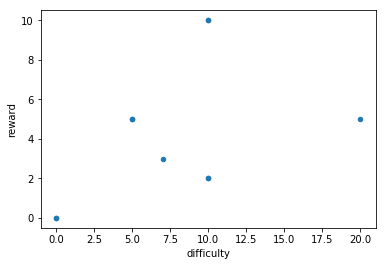

In [131]:
#scatter plot of the diffculty versus the reward
portfolio.plot( 'difficulty' , 'reward', kind = 'scatter')

The duration typiccaly spans 3 to 10 days, and usually is done on multiple support. We will probably have to create dummy variable for the support.

### 1.b Profile

Profile table contains all customers data that is available. Like any customer data, it is likely to be incomplete or is ubject to data error. We start by having a look at the quantitative data: age, became_member_on and income.

In [132]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


became_member_on clearly needs formating, the age percentile seems quite high. I rarely seem 25 % of 73y + at starbucks.


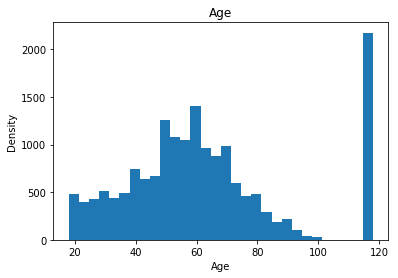

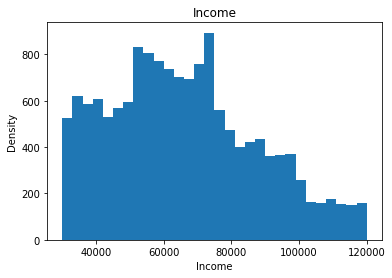

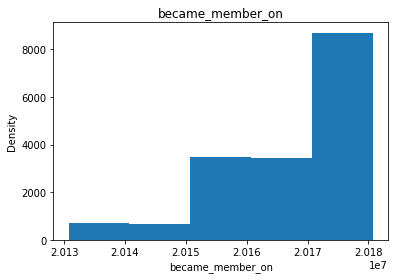

(2175, 5)

In [133]:

# plot the age
plt.hist(profile.age, bins = 30);
plt.xlabel('Age');
plt.ylabel('Density');
plt.title('Age');
plt.show()
#profile.plot(   'income',kind='bar' ,  ax=axes[0,1])

plt.hist(profile.income, bins = 30);
plt.xlabel('Income');
plt.ylabel('Density');
plt.title('Income');
plt.show()
plt.hist(profile.became_member_on, bins = 5);
plt.xlabel('became_member_on');
plt.ylabel('Density');
plt.title('became_member_on');
plt.show()
profile[profile.age>110].shape

There is an issue with age (2175 older than 110 years old), probably linked to the 2175 incomplete applications. The date format will have to be corrected and is unevenly distributed accross the years.  

In [134]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Regarding the 2 qualitative variable: id and gender, we perform grouping

In [135]:
print(profile.groupby('gender').age.count())
print(profile.groupby('gender').age.count().sum() - profile.shape[0])
print(profile.nunique().id/profile.shape[0])

gender
F    6129
M    8484
O     212
Name: age, dtype: int64
-2175
1.0


Good news, we do not seem to have duplicate of ids.  Main issue is the unknown that are in the dataset which amount to 2175. It seems that some applications were simply incomplete because both the gender and the income are missing.

### Since we will try to forecast the best promotion for groups of individual based on demographics, we will  delete incomplete applications


### 1.c Transcript
The file contain what was the outcome of each promotion for each individuals

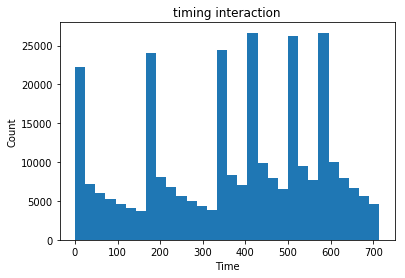

In [136]:
# simple plot of the timing of all interaction recorded
plt.hist(transcript.time, bins = 30);
plt.xlabel('Time');
plt.ylabel('Count');
plt.title('timing interaction');
plt.show()


the spikes look a bit suspicious. They probably match with time the offers are sent off offer. Lets confirm that:

Let's investigate further:

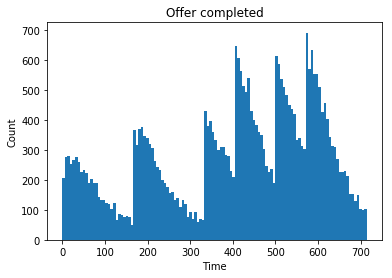

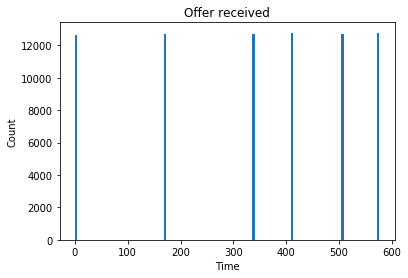

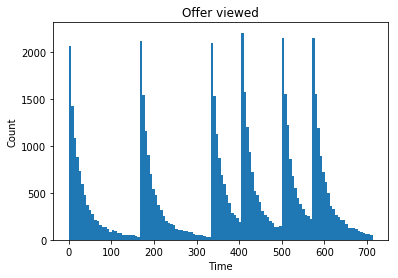

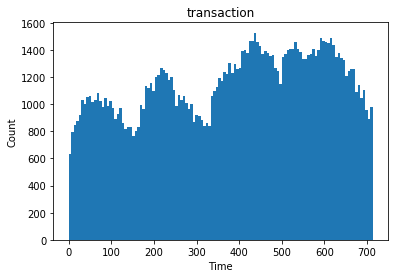

In [137]:
plt.hist(transcript.time[transcript.event=='offer completed'], bins = 120);
plt.xlabel('Time');
plt.ylabel('Count');
plt.title('Offer completed');
plt.show()
                         
plt.hist(transcript.time[transcript.event=='offer received'], bins = 120);
plt.xlabel('Time');
plt.ylabel('Count');
plt.title('Offer received');
plt.show()
                                                  
plt.hist(transcript.time[transcript.event=='offer viewed'], bins = 120);
plt.xlabel('Time');
plt.ylabel('Count');
plt.title('Offer viewed');
plt.show()
                         
                         
plt.hist(transcript.time[transcript.event=='transaction'], bins = 120);
plt.xlabel('Time');
plt.ylabel('Count');
plt.title('transaction');
plt.show()

We can have a look at the number of events per person

In [138]:
transcript.groupby('person' ).count().mean().event

18.031411764705883

So each person in the subset there was an average of 18 interaction.
obviously we will have to do some data processing to use  the value field. We will have a look at this in the next part.

# 2. Data Pre-Processing

Here is our roadmap for the data processing:  
#### a. for the porfolio create dummies for channel and promotion type
#### b. Remove customers without demographic information  
#### c. Ensure completeness of the data of profile dataframe  
#### d. create dummy on Gender  
#### e. process the become_member_on  
#### f. create dummy on Event for transcript  
#### g. Process the Value field  
#### h. Merge all the data in one usable data frame

### 2.a. Create dummies for channel and promotion type

In [139]:
# create dummy for email,social,media, web
portfolio['email'] = 0
portfolio['social'] = 0
portfolio['mobile'] = 0
portfolio['web'] = 0
# first we do the channels
portfolio.email = portfolio.channels.apply( lambda row : 1 if('email' in row) else 0)
portfolio.social = portfolio.channels.apply( lambda row : 1 if('social' in row) else 0)
portfolio.mobile = portfolio.channels.apply( lambda row : 1 if('mobile' in row) else 0)
portfolio.web = portfolio.channels.apply( lambda row : 1 if('web' in row) else 0)
#second, we do the offer_type
portfolio = pd.concat( [portfolio, pd.get_dummies(portfolio.offer_type)],axis =1)
print(portfolio)

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  email  social  \
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10      1       1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10      1       1   
2  3f207df678b143eea3cee63160fa8bed  informational       0      1       0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5      

## 2.b. Remove customers without demographic information

In [140]:
print(profile.shape)
profile= profile.dropna()
print(profile.shape)

(17000, 5)
(14825, 5)


## 2.c. Ensure completeness of the data of profile dataframe

id was complete before so it must be complete now too

## 2.d. Create dummy on Gender

In [141]:
profile = pd.concat( [profile, pd.get_dummies(profile.gender)],axis =1)
print(profile.head())

    age  became_member_on gender                                id    income  \
1    55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
3    75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
5    68          20180426      M  e2127556f4f64592b11af22de27a7932   70000.0   
8    65          20180209      M  389bc3fa690240e798340f5a15918d5c   53000.0   
12   58          20171111      M  2eeac8d8feae4a8cad5a6af0499a211d   51000.0   

    F  M  O  
1   1  0  0  
3   1  0  0  
5   0  1  0  
8   0  1  0  
12  0  1  0  


## 2.e Process the became_member_on

In [142]:
print(profile.became_member_on.head())
profile.became_member_on = profile.became_member_on.apply( lambda row : str(row))
profile.became_member_on =profile.became_member_on.astype('str')
profile.became_member_on = pd.to_datetime( profile.became_member_on, format="%Y%m%d")
print(profile.became_member_on.head())

1     20170715
3     20170509
5     20180426
8     20180209
12    20171111
Name: became_member_on, dtype: int64
1    2017-07-15
3    2017-05-09
5    2018-04-26
8    2018-02-09
12   2017-11-11
Name: became_member_on, dtype: datetime64[ns]


## 2.f. Create dummy on Event for transcript

In [143]:
transcript = pd.concat( [transcript, pd.get_dummies(transcript.event)],axis =1)
print(transcript.head())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  offer completed  \
0  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                0   
1  {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                0   
2  {'offer_id': '2906b810c7d4411798c6938adc9daaa5'}                0   
3  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'}                0   
4  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                0   

   offer received  offer viewed  transaction  
0               1             0            0  
1               1             0            0  
2               1             0            0  
3           

## 2.g. Process the Value field

In [144]:
list(transcript.value[0].keys())[0] == 'offer id'
transcript['offer_id'] =  transcript.value.apply( lambda row :  1 if(list(row.keys())[0] == 'offer_id') else 0 )
transcript['amount'] =transcript.value.apply( lambda row :  1 if(list(row.keys())[0] == 'amount') else 0 )
transcript['offer_id_num'] =transcript.value.apply( lambda row :  list(row.values())[0]  if(list(row.keys())[0] == 'offer_id') else 0 )
transcript['amount_num'] =transcript.value.apply( lambda row :  list(row.values())[0] if(list(row.keys())[0] == 'amount') else 0 )
transcript['reward'] =  transcript.value.apply( lambda row :  1 if(len(list(row.keys())) == 2) else 0 )
transcript['reward_num'] =transcript.value.apply( lambda row :  list(row.values())[1]  if(len(list(row.keys())) == 2) else 0 )

print(transcript.tail(30))

                  event                            person  time  \
306504      transaction  8524d450673b4c24869b6c94380006de   714   
306505      transaction  b895c57e8cd047a8872ce02aa54759d6   714   
306506  offer completed  b895c57e8cd047a8872ce02aa54759d6   714   
306507     offer viewed  8dda575c2a1d44b9ac8e8b07b93d1f8e   714   
306508      transaction  8431c16f8e1d440880db371a68f82dd0   714   
306509  offer completed  8431c16f8e1d440880db371a68f82dd0   714   
306510      transaction  ba620885e51c4b0ea64a4f61daad494f   714   
306511      transaction  a1a8f40407c444cc848468275308958a   714   
306512      transaction  8d80970192fa496f99d6b45c470a4b60   714   
306513      transaction  bde275066f3c4fa0bff3093e3b866a2c   714   
306514      transaction  f1e4fd36e5a0446f83861308bddf6945   714   
306515      transaction  0b64be3b241c4407a5c9a71781173829   714   
306516      transaction  86d03d35d7e0434b935e7743e83be3a0   714   
306517      transaction  3408fd05c781401f8442fb6dbaaea9c7   71

## 2.h. Merge all the data in one usable data frame

To analyze further and apply some machine learning algorithm, we need to merger all the data, together and drop some columns

In [145]:
portfolio = portfolio.drop(['channels' , 'offer_type'],axis = 1)
profile = profile.drop(['gender'],axis = 1)
transcript= transcript.drop(['event', 'value'],axis = 1)
df = transcript.merge(portfolio , how = 'left' ,  left_on ='offer_id_num'  ,right_on='id')
df = df.merge(profile , how = 'left' ,  left_on ='person'  ,right_on='id')
df = df.dropna(subset = ['income'] , axis=0,)
print(df.describe())
print(df[df['offer completed'] ==1 ].tail(10).amount_num)
print(df.columns)

                time  offer completed  offer received   offer viewed  \
count  272762.000000    272762.000000   272762.000000  272762.000000   
mean      366.707694         0.118946        0.243806       0.182797   
std       200.359087         0.323726        0.429378       0.386500   
min         0.000000         0.000000        0.000000       0.000000   
25%       186.000000         0.000000        0.000000       0.000000   
50%       408.000000         0.000000        0.000000       0.000000   
75%       528.000000         0.000000        0.000000       0.000000   
max       714.000000         1.000000        1.000000       1.000000   

         transaction       offer_id         amount     amount_num  \
count  272762.000000  272762.000000  272762.000000  272762.000000   
mean        0.454451       0.545549       0.454451       6.360646   
std         0.497922       0.497922       0.497922      22.509207   
min         0.000000       0.000000       0.000000       0.000000   
25%   

Clearly, this is not the end, the file does combine very different interaction and we will need to engineer features to have a reliable model.

# 3. Problem statement, model design and features needed

What kind of problem are we aiming to solve?  
We want to estimate based on the demographics, which offer method is more effective.  
Here, we already see one major issue: What is effective?  
- It could be just about creating more and more awareness and therefore bringing them to the store to spend money for the one time gain.  
- It could also be more seen on a long term basis. Does it bring value overtime?

Clearly data is missing for the second part, we only have data for about 30 days which probably too little to have such results.  

So we will focus on analysis the following:
- Which time of add is the most effective? (compared to other add and control group)
- Which group is more sensitive to which offer? Is it significant?
- Do any of those leads to more repeated purchase?
- What kind of model can we use to forecast the response to the offer


How do these objectives affects the data we use and the features we need to create.  
We need the get the new time they consume after receiving the offer and whether this affect the amount they consume. This will lead to link several rows from df.
This should allow use to classify the users to one of the offer depending on the extra revenue this may bring.

# 4. Naive forcasting

We focus on the completion rate forecast. We reshape the data to have 1 offer sent = 1 line

In [146]:
def create_data_completion(df=df):
    '''
    Create the data set for the completion rate analysis
    INPUT:
    - DF the data frame from part 3.
    OUTPUT:
    - new_df containing each offer with the outcome on the same line
    '''
#    new_df = df[offer_id_num ~= '0']

    df = df.assign(id_person=(df['person']).astype('category').cat.codes)
    df = df.assign(id_off=(df['offer_id']).astype('category').cat.codes)
    df = df.sort_values(by=['id_person' , 'time'])
    df['time_completed'] =0 # for completed, we will put a 1 when there is a transaction within
    # 7 days = 168h
    df['time_view'] = 0
    # the following looks ugly but traditional search in DataFrame are too slow
    for i in range(df.shape[0]):
        j=i-1
        if df.iloc[i, 2]:
            while df.iloc[i, 0] == df.iloc[j, 0]:
                if df.iloc[j, 5] & (df.iloc[i, 1] == df.iloc[j, 1]) : 
                    df.iloc[  i , 9]= df.iloc[  j , 9] 
                    break
                j-=1
                if j<0:
                    break

    for i in range(df.shape[0]):
        j=i+1
        if df.iloc[i, 3]:
            while df.iloc[i, 0] == df.iloc[j, 0]:
                if df.iloc[j, 4] & (df.iloc[i, 8] == df.iloc[j, 8]) :
                    df.iloc[  i , 33]= df.iloc[  j , 1]   
                #print(df.iloc[i, 22] , df.iloc[j, 5]  , ( (df.iloc[j, 1]-df.iloc[i, 1]) <= (24*df.iloc[i, 13])))
                if int(df.iloc[i, 22]) & df.iloc[j, 5]  :
                    if  (df.iloc[j, 1]-df.iloc[i, 1]) <= (24*df.iloc[i, 13]) :
                        df.iloc[  i , 32]= df.iloc[  j , 1]   
                if df.iloc[j, 2] & (df.iloc[i, 8] == df.iloc[j, 8] ):
                    df.iloc[  i , 32]= df.iloc[  j , 1]   
                    df.iloc[  i , 11]= df.iloc[  j , 11]   
                    df.iloc[  i , 9]= df.iloc[  j , 9] 
                    break
                j+=1

    df=df[df['offer received']==1]

    return df
                    
print(df.columns)
new_df = create_data_completion(df)            

    

Index(['person', 'time', 'offer completed', 'offer received', 'offer viewed',
       'transaction', 'offer_id', 'amount', 'offer_id_num', 'amount_num',
       'reward_x', 'reward_num', 'difficulty', 'duration', 'id_x', 'reward_y',
       'email', 'social', 'mobile', 'web', 'bogo', 'discount', 'informational',
       'age', 'became_member_on', 'id_y', 'income', 'F', 'M', 'O'],
      dtype='object')


In [147]:
print(new_df.columns)
new_df = new_df[['person', 'time', 'offer completed', 'offer received', 'offer viewed',
                     'transaction', 'offer_id', 'amount', 'offer_id_num', 'amount_num',
                     'reward_num', 'difficulty', 'duration',
                     'email', 'social', 'mobile', 'web', 'bogo', 'discount', 'informational', 'reward_y',
                     'age', 'became_member_on', 'income', 'F', 'M', 'O', 'id_person',
                     'id_off', 'time_completed', 'time_view']]

Index(['person', 'time', 'offer completed', 'offer received', 'offer viewed',
       'transaction', 'offer_id', 'amount', 'offer_id_num', 'amount_num',
       'reward_x', 'reward_num', 'difficulty', 'duration', 'id_x', 'reward_y',
       'email', 'social', 'mobile', 'web', 'bogo', 'discount', 'informational',
       'age', 'became_member_on', 'id_y', 'income', 'F', 'M', 'O', 'id_person',
       'id_off', 'time_completed', 'time_view'],
      dtype='object')


In [148]:
def create_time_diff_view(df):
    # create a value for the time from reception to view, 0 if not view
    df['time_diff_view'] =  (df.time_view - df.time)
    df.time_diff_view[ df.time_diff_view<0 ] = 0
    return df
    
def create_time_diff_completed(df):
    # create a value for the time from reception to completed, 0 if not completed
    df['time_diff_completed'] =  (df.time_completed - df.time).apply(lambda row: np.max(row,0))
    df.time_diff_completed[ df.time_diff_completed<0 ] = 0
    return df
    
def create_month_membership(df):
    # create a value for duration of membership, initialisation point is random
    df['membership'] =  df.became_member_on.apply(lambda row: datetime.datetime(year=2018, month= 3, day=30) -  row)  
    return df

def create_categorical_view(df):
    df['view_offer'] =  df['time_diff_view'].apply(lambda row: 1 if row>0 else 0)
    return df

def create_categorical_buy(df):
    df['buy_offer'] =  df['time_diff_completed'].apply(lambda row: 1 if row>0 else 0)
    return df

new_df=create_time_diff_view(new_df)
new_df=create_time_diff_completed(new_df)
new_df=create_month_membership(new_df)
new_df=create_categorical_view(new_df)
new_df=create_categorical_buy(new_df)
new_df.membership = new_df.membership.apply(lambda row : row.total_seconds()/60)

new_df_regression = new_df[[ 'reward_num', 'difficulty', 'duration', 'social', 'mobile',
       'web', 'bogo', 'discount','email', 'informational', 'age','income', 'F', 'M', 'O',  'membership',
       'view_offer', 'buy_offer']]
#print(new_df_regression.tail(20))
print(new_df_regression.describe())

         reward_num   difficulty      duration        social        mobile  \
count  66501.000000  66501.00000  66501.000000  66501.000000  66501.000000   
mean       2.510098      7.71417      6.507571      0.598517      0.898859   
std        3.228628      5.54754      2.204416      0.490202      0.301518   
min        0.000000      0.00000      3.000000      0.000000      0.000000   
25%        0.000000      5.00000      5.000000      0.000000      1.000000   
50%        2.000000     10.00000      7.000000      1.000000      1.000000   
75%        5.000000     10.00000      7.000000      1.000000      1.000000   
max       10.000000     20.00000     10.000000      1.000000      1.000000   

                web          bogo      discount    email  informational  \
count  66501.000000  66501.000000  66501.000000  66501.0   66501.000000   
mean       0.799612      0.399047      0.400956      1.0       0.199997   
std        0.400294      0.489706      0.490096      0.0       0.400001 

So the Data is cleaned and ready to be used for some modeling. First we want to explain classify the offers to use based on the success (being view and got to buy it)

In [149]:
# here we build a first model using a logistic regression which is good to forecast 0,1 
# it mostly work well for linear behaviour
def build_model():
    pipeline = Pipeline([
        ("feature_select", SelectPercentile()),
        ("model", LogisticRegression(random_state=42))
    ])
    params = {
        "feature_select__percentile":[ 100],
    }
    # train the second model

    cv  = GridSearchCV(pipeline, param_grid=params,verbose=0,n_jobs=4,cv=10)
    return cv
def model_data(new_df_regression, y_forcasted, restrict_offer_col =[] ):

    if len(restrict_offer_col) >0:
        diff = set(['bogo', 'discount', 'informational']).difference(   set(restrict_offer_col) )
        X = new_df_regression[new_df_regression[restrict_offer_col[0]] == 1]
        X = X.drop(['bogo', 'discount', 'informational'], axis=1)
    else:
        X = new_df_regression
    if y_forcasted =='view_offer':
        y = X[ 'view_offer']
        X = X.drop(['view_offer', 'buy_offer'], axis=1)
    else: 
        y = X[ 'buy_offer']
        X = X.drop(['view_offer', 'buy_offer'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.45, random_state=42, shuffle=True)

    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Best score and parameter combination = ')
    print(model.best_score_)   
    return model
print('running buy_offer bogo then discount then informational')
model = model_data(new_df_regression, 'buy_offer', restrict_offer_col =['bogo'] )
model_buy_d = model_data(new_df_regression, 'buy_offer', restrict_offer_col =['discount'] )
model = model_data(new_df_regression, 'buy_offer', restrict_offer_col =['informational'] )
print('runnin buy offer all')
model_buy = model_data(new_df_regression, 'buy_offer', restrict_offer_col =[] )

print('running view_offer bogo then discount then informational')
model = model_data(new_df_regression, 'view_offer', restrict_offer_col =['bogo'] )
model = model_data(new_df_regression, 'view_offer', restrict_offer_col =['discount'] )
model = model_data(new_df_regression, 'view_offer', restrict_offer_col =['informational'] )
print('runnin view_offer all')
model = model_data(new_df_regression, 'view_offer', restrict_offer_col =[] )

running buy_offer bogo then discount then informational
Best score and parameter combination = 
0.5636176772867421
Best score and parameter combination = 
0.6336856460961473
Best score and parameter combination = 
0.6187286397812714
runnin buy offer all
Best score and parameter combination = 
0.5980314422419686
running view_offer bogo then discount then informational
Best score and parameter combination = 
0.573963686193902
Best score and parameter combination = 
0.5731333106034777
Best score and parameter combination = 
0.6180451127819548
runnin view_offer all
Best score and parameter combination = 
0.5468215994531784


Are the results good?
For the view forecast: not at all. 54% of correct prediction is exactly the result you would have by saying every single offer will lead to the consumer viewing it. For the buying, we do much better because we managed 59%.


# 5. Data Science in a smarter way

So we put everything we had into 1 model and this did not produce meaningful result. We go back to the drwaing board and try to get some more insight into some useful correlations that can help us to build a model.

In this part, we analyse first analyse correlation between democraphics and completion of offer.

## 5.a Age




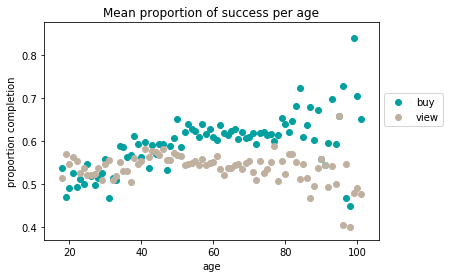

In [150]:
# define a function to help plot figures
def plot_age_trans_mean(df):
    '''Plot scatters, x axis is age, y axis is mean value of completion
    INPUT:
        the complete data frame of the data from above
    OUTPUT:
        the figure
    '''
    view_avg_by_age = df.groupby('age').mean()['view_offer']
    avg_by_age = df.groupby('age').mean()['buy_offer']
    plt.scatter(avg_by_age.index, avg_by_age, color = '#00A0A0');
    plt.scatter(view_avg_by_age.index, view_avg_by_age, color = '#C0B0A0');
    plt.xlabel('age');
    plt.legend(['buy', 'view'], bbox_to_anchor=(1.00, 0.5), loc=3);
plot_age_trans_mean(new_df_regression)
plt.ylabel('proportion completion');
plt.title('Mean proportion of success per age', fontsize=12);

Here, it get more interesting:
- First the likelyhood of a buy following an offer is larger with the age
- Secondly the behavior is difference for viewing it.
Some older people do use the offer without seeing them? possible.

To go further, we can have a look at whether their is difference per offer

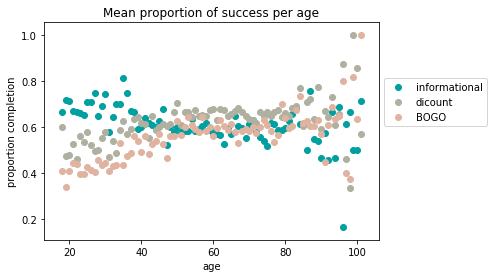

In [151]:
def plot_age_offer_mean(df_ori, col = 'buy_offer'):
    '''Plot scatters, x axis is age, y axis is mean value of completion
    INPUT:
        the complete data frame of the data from above
    OUTPUT:
        the figure
    '''
    df = df_ori[df_ori.informational == 1 ]
    info_avg_by_age = df.groupby('age').mean()[col]
    df = df_ori[df_ori.discount == 1 ]
    dis_avg_by_age = df.groupby('age').mean()[col]
    df = df_ori[df_ori.bogo == 1 ]
    bogo_avg_by_age = df.groupby('age').mean()[col]
    plt.scatter(info_avg_by_age.index, info_avg_by_age, color = '#00A0A0');
    plt.scatter(dis_avg_by_age.index, dis_avg_by_age, color = '#B0B0A0');
    plt.scatter(bogo_avg_by_age.index, bogo_avg_by_age, color = '#E0B3A0');
    plt.xlabel('age');
    plt.legend(['informational', 'dicount', 'BOGO'], bbox_to_anchor=(1.00, 0.5), loc=3);
plot_age_offer_mean(new_df_regression)
plt.ylabel('proportion completion');
plt.title('Mean proportion of success per age', fontsize=12);

The picture is clearer here, Informational offer and considered succesfull if there is one consumption within 1 week and this is probably too optimistic because it assumes that the comsuption is coming from this add but this is unlikely to be the case.  
One other interesting fact is that discount offer are constently above the the BOGO offers in term of completion rates.  
Such offer are more effective for people in the age bracket of 45-70 year old.

## 5.b Income

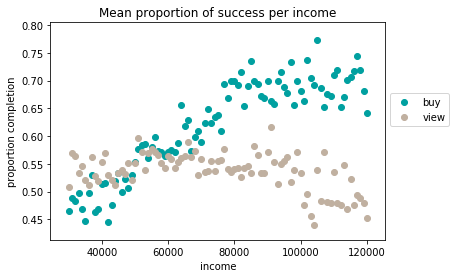

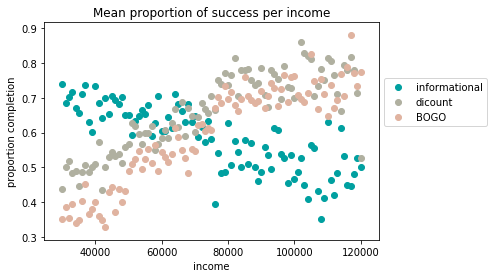

In [152]:
def plot_income_trans_mean(df):
    '''Plot scatters, x axis is income, y axis is mean value of completion
    INPUT:
        the complete data frame of the data from above
    OUTPUT:
        the figure
    '''
    view_avg_by_age = df.groupby('income').mean()['view_offer']
    avg_by_age = df.groupby('income').mean()['buy_offer']
    plt.scatter(avg_by_age.index, avg_by_age, color = '#00A0A0');
    plt.scatter(view_avg_by_age.index, view_avg_by_age, color = '#C0B0A0');
    plt.xlabel('income');
    plt.legend(['buy', 'view'], bbox_to_anchor=(1.00, 0.5), loc=3);
def plot_income_offer_mean(df_ori, col = 'buy_offer'):
    '''Plot scatters, x axis is income, y axis is mean value of completion
    INPUT:
        the complete data frame of the data from above
    OUTPUT:
        the figure
    '''
    df = df_ori[df_ori.informational == 1 ]
    info_avg_by_age = df.groupby('income').mean()[col]
    df = df_ori[df_ori.discount == 1 ]
    dis_avg_by_age = df.groupby('income').mean()[col]
    df = df_ori[df_ori.bogo == 1 ]
    bogo_avg_by_age = df.groupby('income').mean()[col]
    plt.scatter(info_avg_by_age.index, info_avg_by_age, color = '#00A0A0');
    plt.scatter(dis_avg_by_age.index, dis_avg_by_age, color = '#B0B0A0');
    plt.scatter(bogo_avg_by_age.index, bogo_avg_by_age, color = '#E0B3A0');
    plt.xlabel('income');
    plt.legend(['informational', 'dicount', 'BOGO'], bbox_to_anchor=(1.00, 0.5), loc=3);
plot_income_trans_mean(new_df_regression)
plt.ylabel('proportion completion');
plt.title('Mean proportion of success per income', fontsize=12);
plt.show()
plot_income_offer_mean(new_df_regression)
plt.ylabel('proportion completion');
plt.title('Mean proportion of success per income', fontsize=12);

So the wealthier you are, the more you tend to use discount and BOGO offer. 
This is probably link to the fact that they go to Starbucks more frequently. One more time, the relation is not really linear.

## 5.c Membership 

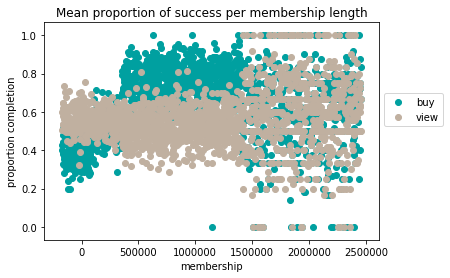

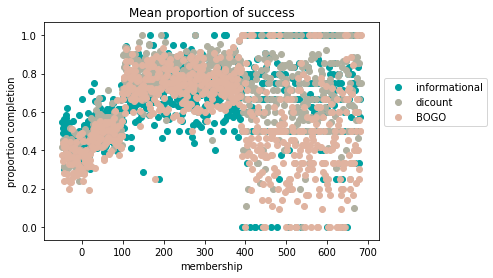

In [153]:
def plot_membership_trans_mean(df):
    '''Plot scatters, x axis is membership, y axis is mean value of completion
    INPUT:
        the complete data frame of the data from above
    OUTPUT:
        the figure
    '''
    view_avg_by_age = df.groupby('membership').mean()['view_offer']
    avg_by_age = df.groupby('membership').mean()['buy_offer']
    plt.scatter(avg_by_age.index, avg_by_age, color = '#00A0A0');
    plt.scatter(view_avg_by_age.index, view_avg_by_age, color = '#C0B0A0');
    plt.xlabel('membership');
    plt.legend(['buy', 'view'], bbox_to_anchor=(1.00, 0.5), loc=3);
def plot_membership_offer_mean(df_ori, col = 'buy_offer'):
    '''Plot scatters, x axis is membership, y axis is mean value of completion
    INPUT:
        the complete data frame of the data from above
    OUTPUT:
        the figure
    '''
    df_ori.membership = (df_ori.membership/3600).apply(np.floor)
    df = df_ori[df_ori.informational == 1 ]
    info_avg_by_age = df.groupby('membership').mean()[col]
    df = df_ori[df_ori.discount == 1 ]
    dis_avg_by_age = df.groupby('membership').mean()[col]
    df = df_ori[df_ori.bogo == 1 ]
    bogo_avg_by_age = df.groupby('membership').mean()[col]
    plt.scatter(info_avg_by_age.index, info_avg_by_age, color = '#00A0A0');
    plt.scatter(dis_avg_by_age.index, dis_avg_by_age, color = '#B0B0A0');
    plt.scatter(bogo_avg_by_age.index, bogo_avg_by_age, color = '#E0B3A0');
    plt.xlabel('membership');
    plt.legend(['informational', 'dicount', 'BOGO'], bbox_to_anchor=(1.00, 0.5), loc=3);
plot_membership_trans_mean(new_df_regression)
plt.ylabel('proportion completion');
plt.title('Mean proportion of success per membership length', fontsize=12);
plt.show()
plot_membership_offer_mean(new_df_regression)
plt.ylabel('proportion completion');
plt.title('Mean proportion of success', fontsize=12);

Results are less intuitive here, but they do suggest that the more you stay in the program, the more you use the offer. 

## 5.d Which channel?

In [154]:
col = ['buy_offer' , 'view_offer']
print(new_df_regression.columns)
print(new_df_regression.groupby( ['informational' , 'bogo' , 'discount']).mean()[col])
print(new_df_regression.groupby( ['social', 'mobile', 'web' , 'email']).mean()[col])

Index(['reward_num', 'difficulty', 'duration', 'social', 'mobile', 'web',
       'bogo', 'discount', 'email', 'informational', 'age', 'income', 'F', 'M',
       'O', 'membership', 'view_offer', 'buy_offer'],
      dtype='object')
                             buy_offer  view_offer
informational bogo discount                       
0.0           0.0  1.0        0.629838    0.483873
              1.0  0.0        0.556581    0.574971
1.0           0.0  0.0        0.612556    0.615414
                         buy_offer  view_offer
social mobile web email                       
0.0    0.0    1.0 1.0     0.509961    0.271781
       1.0    1.0 1.0     0.600561    0.406299
1.0    1.0    0.0 1.0     0.571965    0.694357
              1.0 1.0     0.629400    0.647719


The only interesting conclusion is that more channels used = more reach. Web and email appear to be the weakest.

## 6. Reward, duration, amount spent and difficulty

We still have to analyse whether the characteristics of the offer impact the proportion using it and if the amount and reward consumers are getting has an importance.

,reward_num,difficulty,duration,amount_num,bogo,discount,email,informational,age,income,F,M,O,membership,view_offer,buy_offer
reward_y,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,3.500526,0.000000,0.000000,0.000000,1.0,1.0,54.559850,65371.729323,0.416391,0.568947,0.014662,581613.293233,0.615414,0.612556
2.0,1.381314,10.000000,8.502371,13.604972,0.000000,1.000000,1.0,0.0,54.295265,65434.841527,0.408341,0.578408,0.013250,581165.917338,0.514417,0.651359
3.0,2.263862,7.000000,7.000000,13.523163,0.000000,1.000000,1.0,0.0,54.269872,65228.099174,0.408415,0.577761,0.013824,569207.224643,0.637265,0.708039
5.0,3.049982,10.047781,7.351528,12.769649,0.663481,0.336519,1.0,0.0,54.410517,65274.778606,0.414720,0.570871,0.014409,583033.860009,0.424826,0.573173
10.0,5.464748,10.000000,6.006779,13.062291,1.000000,0.000000,1.0,0.0,54.240057,65525.986743,0.413302,0.574269,0.012428,586163.193733,0.647409,0.507984


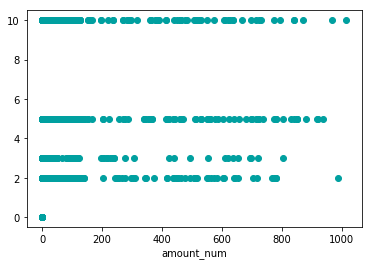

In [155]:
df_amount = new_df[[ 'reward_num', 'difficulty', 'duration', 'amount_num' ,'reward_y',
                    'bogo', 'discount','email', 'informational', 'age','income', 'F', 'M', 'O',  'membership',
                    'view_offer', 'buy_offer']]
def plot_reward_amount(df):
    '''Plot scatters, x axis is age, y axis is mean value of completion
    '''

    plt.scatter(df.amount_num, df.reward_y, color = '#00A0A0');
    plt.xlabel('amount_num');
    
plot_reward_amount(df_amount)
df_amount.groupby('reward_y').mean()

Looking at the last 2 columns, we see an interesting pattern: the higher the reward does not mean the higher completion rate.
This is linked to fact that these campaigns are mostly BOGO while discount promotion attract more people.

## 7. A more refined model

Can we get a better model than before to forcast the sucess of a campaing. First we go back to the forecast of whether someone will use the offer or now then we move to the amount and the return on the offer.

## 7.a Random forest

In [156]:
from sklearn.ensemble import RandomForestClassifier
def build_model():
    pipeline = Pipeline([
        ("feature_select", SelectPercentile()),
        ("model", RandomForestClassifier(random_state=42))
    ])
    params = {
        "feature_select__percentile":[ 100],
        'model__bootstrap': [False, True],
         'model__n_estimators': [80 , 130],
         'model__max_features': [0.6, 0.7, 0.8],
         'model__min_samples_leaf': [10 , 14],
         'model__min_samples_split': [3,  7]
        },
    # train the second model

    cv  = GridSearchCV(pipeline, param_grid=params,verbose=3,n_jobs=4,cv=5)
    return cv
def model_data(new_df_regression, y_forcasted, restrict_offer_col =[]  ,printing =0):

    if len(restrict_offer_col) >0:
        diff = set(['bogo', 'discount', 'informational']).difference(   set(restrict_offer_col) )
        X = new_df_regression[new_df_regression[restrict_offer_col[0]] == 1]
        X = X.drop(['bogo', 'discount', 'informational'], axis=1)
    else:
        X = new_df_regression
    if y_forcasted =='view_offer':
        y = X[ 'view_offer']
        X = X.drop(['view_offer', 'buy_offer'], axis=1)
    else: 
        y = X[ 'buy_offer']
        X = X.drop(['view_offer', 'buy_offer'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.45, random_state=42, shuffle=True)

    model = build_model()
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Result on the test sample: ')
    print(1- np.sum((y_pred - y_test.values)**2) / len(y_test))
    print('Result on the train')
    print(model.best_score_)   
    dataF =pd.DataFrame(data = {  'col' : X_train.columns ,                      
                     'values buying' :model.best_estimator_.steps[1][1].feature_importances_ })
    print(dataF.sort_values(by='values buying' , ascending =False))
    return model
df_amount = df_amount[[  'difficulty', 'duration','reward_y',
                    'bogo', 'discount','email', 'informational', 'age','income', 'F', 'M',  'membership',
                    'view_offer', 'buy_offer']]
print('running buy_offer bogo then discount then informational')
model = model_data(df_amount, 'buy_offer', restrict_offer_col =['bogo'] )
model_buy_d = model_data(df_amount, 'buy_offer', restrict_offer_col =['discount'] )
model = model_data(df_amount, 'buy_offer', restrict_offer_col =['informational'] )
print('runnin buy offer all')
model_buy = model_data(df_amount, 'buy_offer', restrict_offer_col =[] , printing =1 )
from sklearn.externals import joblib
# Output a pickle file for the model
joblib.dump(model_buy, 'model_buy.pkl') 
print('running view_offer bogo then discount then informational')
model = model_data(df_amount, 'view_offer', restrict_offer_col =['bogo'] )
model = model_data(df_amount, 'view_offer', restrict_offer_col =['discount'] )
model = model_data(df_amount, 'view_offer', restrict_offer_col =['informational'] )
print('runnin view_offer all')
model_view = model_data(df_amount, 'view_offer', restrict_offer_col =[] )

running buy_offer bogo then discount then informational
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  3.5min finished


Result on the test sample: 
0.6929325071177357
Result on the train
0.6929085303186022
          col  values buying
8  membership       0.440911
5      income       0.246076
4         age       0.170656
7           M       0.034840
0  difficulty       0.032189
2    reward_y       0.030661
1    duration       0.029003
6           F       0.015665
3       email       0.000000
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  3.2min finished


Result on the test sample: 
0.7148095674639554
Result on the train
0.7196045005114218
          col  values buying
8  membership       0.491315
5      income       0.219438
4         age       0.129326
2    reward_y       0.045914
0  difficulty       0.045634
1    duration       0.028500
7           M       0.023310
6           F       0.016564
3       email       0.000000
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  1.5min finished


Result on the test sample: 
0.6270676691729323
Result on the train
0.6351332877648667
          col  values buying
8  membership       0.455853
5      income       0.278848
4         age       0.197358
1    duration       0.038655
6           F       0.016783
7           M       0.012504
0  difficulty       0.000000
2    reward_y       0.000000
3       email       0.000000
runnin buy offer all
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 10.4min finished


Result on the test sample: 
0.6966183252021654
Result on the train
0.6899248120300752
              col  values buying
11     membership       0.433870
8          income       0.207760
7             age       0.167733
2        reward_y       0.061038
0      difficulty       0.036852
1        duration       0.036515
10              M       0.027683
9               F       0.011683
3            bogo       0.006912
4        discount       0.005992
6   informational       0.003962
5           email       0.000000
running view_offer bogo then discount then informational
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  3.7min finished


Result on the test sample: 
0.6349857645285547
Result on the train
0.6322713257965057
          col  values buying
8  membership       0.285441
5      income       0.224851
4         age       0.198202
1    duration       0.135180
2    reward_y       0.073010
0  difficulty       0.056693
7           M       0.013776
6           F       0.012847
3       email       0.000000
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  3.8min finished


Result on the test sample: 
0.6613884490374198
Result on the train
0.6505284691442209
          col  values buying
8  membership       0.229539
5      income       0.203500
4         age       0.178598
2    reward_y       0.153261
0  difficulty       0.116892
1    duration       0.093329
7           M       0.014258
6           F       0.010622
3       email       0.000000
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  1.9min finished


Result on the test sample: 
0.6736842105263158
Result on the train
0.6843472317156528
          col  values buying
8  membership       0.290019
1    duration       0.247499
5      income       0.227432
4         age       0.199613
6           F       0.019036
7           M       0.016400
0  difficulty       0.000000
2    reward_y       0.000000
3       email       0.000000
runnin view_offer all
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 12.7min finished


Result on the test sample: 
0.6534451647396913
Result on the train
0.6497607655502392
              col  values buying
11     membership       0.249755
8          income       0.209211
7             age       0.180306
0      difficulty       0.137253
1        duration       0.130288
2        reward_y       0.049273
10              M       0.014795
9               F       0.012923
4        discount       0.006220
3            bogo       0.006130
6   informational       0.003846
5           email       0.000000


In [157]:

from sklearn.tree import export_graphviz

def save_tree_pic(model):
    data_feature_names = [  'difficulty', 'duration','reward_y',
                        'bogo', 'discount','email', 'informational', 'age','income', 'F', 'M',  'membership',],


    # Visualize data https://pythonprogramminglanguage.com/decision-tree-visual-example/
    dot_data = export_graphviz(model_buy.best_estimator_,
                                    feature_names=data_feature_names,
                                    out_file=None,
                                    filled=True,
                                    rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)

    colors = ('turquoise', 'orange')
    edges = collections.defaultdict(list)

    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))

    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]
            dest.set_fillcolor(colors[i])

    graph.write_png('tree.png')

This gives a model to evaluate the potential impact of a campain.
              col  values buying  
11     membership       0.433870  
8          income       0.207760  
7             age       0.167733  
2        reward_y       0.061038  
0      difficulty       0.036852  
1        duration       0.036515  
10              M       0.027683  
9               F       0.011683  
3            bogo       0.006912  
4        discount       0.005992  
6   informational       0.003962  
5           email       0.000000  

The main features are actually the length of the menbership, income and age. The type of campain matters a lot less.

Imagine you think of 2 campaing but you are unsure which one would be the best for who. You know you want to give them the same rewards but you want to maximise the effectiveness of the campaign.  
Please note the membership time is in second.
In the example below, for a member with the same characteristics except the length of the membership, we have very different probability of success.  
Changing the offer to bogo makes a tiny difference but not enough to predict success.


In [158]:
X_new =pd.DataFrame( data = { 'difficulty' : [5], 'duration' :[5],'reward_y':[10],
                        'bogo':[0], 'discount':[1],'email':[0], 'informational':[0],
                      'age':[25],'income':[60000],
                      'F':[0], 'M':[1], 
                      'membership':[1000]})
model_buy = joblib.load('model_buy.pkl') 
print(' for membership of 1000 seconds')
print(model_buy.predict(X_new ))
print(model_buy.predict_proba(X_new ))
X_new =pd.DataFrame( data = { 'difficulty' : [5], 'duration' :[5],'reward_y':[10],
                        'bogo':[0], 'discount':[1],'email':[0], 'informational':[0],
                      'age':[25],'income':[60000],
                      'F':[0], 'M':[1], 
                      'membership':[1000000]})
print(' for membership of 1000000 seconds')
print(model_buy.predict(X_new ))
print(model_buy.predict_proba(X_new ))
X_new =pd.DataFrame( data = { 'difficulty' : [5], 'duration' :[5],'reward_y':[10],
                        'bogo':[1], 'discount':[0],'email':[0], 'informational':[0],
                      'age':[25],'income':[60000],
                      'F':[0], 'M':[1], 
                      'membership':[1000]})
print(model_buy.predict(X_new ))
print(model_buy.predict_proba(X_new ))

 for membership of 1000 seconds
[0]
[[0.68634165 0.31365835]]
 for membership of 1000000 seconds
[1]
[[0.28765564 0.71234436]]
[0]
[[0.671895 0.328105]]


# 8 Conclusion

We provide a fairly reliable way to assess the likelyhood that a promotion will reach the its customer and be used. 
Using this, we can reliabily assess the effectivness of proposed campain.
You can also find the medium post:
https://medium.com/starbucks-who-to-give-discount-to/a-random-forest-approach-to-selecting-who-should-receive-which-offer-46adc09adb21